In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
! pip install "transformers" "pytorch-lightning"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.8 MB/s 
     |████████████████████████████████| 705 kB 70.6 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 5.9 MB 49.5 MB/s 
     |████████████████████████████████| 419 kB 64.0 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [ ]:
import json
import pandas as pd
import numpy as np
import time
import heapq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = 0
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
categories = ["aria aperta", "cultura",	"eventi culinari", "food", "food all'aperto", "food drink",	"sport",	"tempo libero", "travel",	"viaggi"]

In [ ]:
likes_path = "/content/drive/MyDrive/Tesi/kuriu-likes-2022-06JUN-18.json"
schede_path = "/content/drive/MyDrive/Tesi/kuriu-schede-2022-06JUN-18.json"
#data_path = "/content/drive/MyDrive/Tesi/data-JUN.csv"
data_path = "/content/drive/MyDrive/Tesi/data-JUN-no-stemming.csv"

df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path, encoding_errors='ignore')  

df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "categories", "viewCounter"]]
df_likes_ids = df_likes[["documentId", "authorId"]]

In [ ]:
df_schede

,id,userId,userName,documentType,title,description,locations,duration,imageId,previewId,...,version,media,shareType,status,lastUpdate,versionHistory,viewCounter,device,crowdPosting,activeCrowdPosting
0,62349ff2272ae5672fbc3135,632,Forestlife_Adventure,experience,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,[{'photoReference': 'Aap_uEA4LhCYzVzbaHBUWsYoz...,0,62349c0c272ae5672fbc30d6,None,...,5,{'photos': [{'fileId': '62349c0c272ae5672fbc30...,SHARED,PUBLISHED,2022-04-20T12:54:13.563Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",18,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
1,6234aa65272ae5672fbc34c2,632,Forestlife_Adventure,experience,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",[{'photoReference': 'Aap_uEDR-tkPt3POWYoKoWcHy...,0,6234a758272ae5672fbc32aa,None,...,5,{'photos': [{'fileId': '6234a758272ae5672fbc32...,SHARED,PUBLISHED,2022-04-20T12:54:13.586Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",16,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
2,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,10800000,620aa384ff8ae67f37cafaf9,None,...,7,{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",426,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
3,624e5982ec9ff859ff529ce8,571,tiportoviaconme,experience,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,[{'photoReference': 'Aap_uEDCSLsqxhvyp9pUEmR5R...,0,624e5916ec9ff859ff529c90,None,...,3,{'photos': [{'fileId': '624e5916ec9ff859ff529c...,SHARED,PUBLISHED,2022-04-07T03:24:50.535Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",6,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A...",NaN,False
4,620abb33ff8ae67f37cafe3c,442,lollo_cata,experience,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,[{'photoReference': 'Aap_uECP3iO80ReEkce8JB_2s...,18000000,620ab9e4ff8ae67f37cafe30,None,...,8,{'photos': [{'fileId': '620ab9e4ff8ae67f37cafe...,SHARED,PUBLISHED,2022-02-14T20:27:31.966Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",424,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,Elle_,experience,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",[{'photoReference': 'Aap_uEASvi2g7Xd91-_ojmvmi...,21600000,6213b3000f41f86438b07cad,None,...,6,{'photos': [{'fileId': '6213b3000f41f86438b07c...,SHARED,PUBLISHED,2022-04-22T14:14:59.961Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",47,"{'deviceModel': 'iPhone 8', 'deviceOS': 'iOS',...",NaN,False
5720,61dd867f9c823e129b1f2cc2,429,Elle_,experience,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,[{'photoReference': 'Aap_uEBZ0EHCQ9HgiQWe89I7L...,7200000,61dd860e9c823e129b1f2c7b,None,...,6,{'photos': [{'fileId': '61dd860e9c823e129b1f2c...,SHARED,PUBLISHED,2022-04-22T14:14:59.815Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",95,None,NaN,False
5721,61e0146111b3bf4d3185ad5d,427,teretacchi,experience,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,[{'photoReference': 'Aap_uECe7KHh6UtQvIdb8g3JL...,16200000,61e0134011b3bf4d3185ad2f,None,...,6,{'photos': [{'fileId': '61e0134011b3bf4d3185ad...,SHARED,PUBLISHED,2022-01-13T12:04:33.749Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",63,None,NaN,False
5722,6273a0a9dd67f6198e5ac192,606,DaleOnTravel,experience,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,[{'photoReference': 'Aap_uEBtY1EzLnQqBMoci7nIs...,0,6273a0a7dd67f6198e5ac165,6273a03add67f6198e5ac12c,...,2,{'photos': [{'fileId': '6273a0a7

In [ ]:
data

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,Unnamed: 9,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,['Viaggi'],18,0,...,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,150
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,['Viaggi'],16,0,...,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,150
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,['Viaggi'],426,0,...,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,182
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,['Viaggi'],6,0,...,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,131
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,['Viaggi'],424,0,...,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,['Viaggi'],47,0,...,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,175
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,['Aria aperta'],95,0,...,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,217
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,['Cultura'],63,0,...,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,215
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,['Viaggi'],7,0,...,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,103


#User/likes distribution

In [ ]:
df_likes_ids.authorId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
2        True
4        True
5        True
        ...  
2252    False
2312     True
2415     True
2447     True
2488     True
Name: authorId, Length: 123, dtype: bool

In [ ]:
#list of users, some ids in likes are not in posts -> some users liked posts but not posted one
users = pd.concat([df_likes_ids.authorId, data.userId]).drop_duplicates() 
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
#list of posts and users that liked that post
posts_with_likes = df_likes_ids.groupby("documentId").authorId.apply(list)
#list of users and posts they liked
users_with_likes = df_likes_ids.groupby("authorId").documentId.apply(list)
#users that have not posted anything
users_without_posts = users[~users.isin(users_posts.index)].values
#users that did not like any posts
users_without_likes_made = users[~users.isin(users_with_likes.index)].values
#posts that did not receive any likes
posts_without_likes = posts[~posts.isin(posts_with_likes.index)].values

print("Total number of users: {}".format(len(users)))
print("Number of posts: {}".format(len(posts)))
print("Number of users that posted something: {}".format(len(users_posts)))
print("Number of posts that received likes: {}".format(len(posts_with_likes)))
print("Total number of likes: {}".format(posts_with_likes.str.len().sum())) 
print("Number of users that liked posts: {}".format(len(users_with_likes)))
print("Number of users that not posted anything: {}".format(len(users_without_posts)))
print("Number of users that not liked anything: {}".format(len(users_without_likes_made)))
print("Number of posts that not received likes: {}".format(len(posts_without_likes)))

Total number of users: 187
Number of posts: 5724
Number of users that posted something: 156
Number of posts that received likes: 1708
Total number of likes: 2542
Number of users that liked posts: 123
Number of users that not posted anything: 31
Number of users that not liked anything: 64
Number of posts that not received likes: 4016


In [ ]:
users_posts

userId
77     [6154833edee05f1877c59be1, 628788d1daa33c0b122...
119    [60f6d6864250196f9f64270c, 60f6d2f54250196f9f6...
129    [61408190533f2f326b89392b, 61c4a8f3ad15dc51e7f...
149    [6190e32f068a0f468cc78c24, 620fd14f4f9d177c90f...
150    [62263e1161e055356b8a0a84, 62696dc958dee574819...
                             ...                        
680    [6172dc0672b6f336088b97d9, 627b88ba99ceaf5fe8a...
688    [62964070ab3f2a603ac2f87d, 62ab0394d1fdac049a8...
704                           [62ade69843ccd92351666123]
706    [62aba03dca80fa55f9a54713, 62add00043ccd923516...
708                           [62ab39eb124e6a3ebfb3115e]
Name: id, Length: 156, dtype: object

In [ ]:
users_posts_timestamps = dict()
for u, val in users_posts.iteritems():
  users_posts_timestamps[u] = []
  for p in val:
    date_series = df_schede[df_schede.id==p].creationDate
    date = date_series.values[0]
    users_posts_timestamps[u].append((p, date))

for u in users_posts_timestamps.keys():
  users_posts_timestamps[u].sort(key=lambda tup: tup[1])

In [ ]:
users_with_likes

authorId
119    [623d6faf8e8767135be14713, 62732a14dd67f6198e5...
129    [615acf21eb3bf47494b8e64b, 61aa039788b2e606829...
149    [62480d4430f1cc3afdc3cc03, 622f5c4546ef2b6d71a...
150    [61f3c801d91e9928f6e09231, 61ee5e468e21a651054...
157    [6181141d21889d3548fee8ef, 616596b12efc02402cc...
                             ...                        
696                           [629dd9d29323cd6041204345]
697    [629de0489323cd6041204395, 620eb707a5618a14af5...
698                           [6299e10f8b09c758f866da25]
699                           [623a3af9f2e22812c750d012]
700                           [6149f0dd00ce352eefee574e]
Name: documentId, Length: 123, dtype: object

In [ ]:
users_likes_timestamps = dict()
for u, val in users_with_likes.iteritems():
  users_likes_timestamps[u] = []
  for p in val:
    date_series = df_schede[df_schede.id==p].creationDate
    date = date_series.values[0]
    users_likes_timestamps[u].append((p, date))

for u in users_likes_timestamps.keys():
  users_likes_timestamps[u].sort(key=lambda tup: tup[1])

In [ ]:
data_with_ids = data.drop(columns=["datePublishing", "categories", "creationDate", "duration", "description", "title", "viewCounter"])

In [ ]:
#"duration_min", "days"
X = data.drop(columns=["id", "userId", "description","categories", "title", "datePublishing", "creationDate", "duration", "viewCounter"])

In [ ]:
X

,Unnamed: 9,aria aperta,cultura,eventi culinari,food,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,0,0,0,0,0,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,150
1,0,0,0,0,0,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,150
2,0,0,0,0,0,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,182
3,0,0,0,0,0,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,131
4,0,0,0,0,0,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,0,0,0,0,0,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,175
5720,0,1,0,0,0,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,217
5721,0,0,1,0,0,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,215
5722,0,0,0,0,0,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,103


In [ ]:
data

,id,userId,title,description,duration,datePublishing,creationDate,categories,viewCounter,Unnamed: 9,...,food all'aperto,food drink,sport,tempo libero,travel,viaggi,title_processed,description_processed,duration_min,days
0,62349ff2272ae5672fbc3135,632,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,['Viaggi'],18,0,...,0,0,0,0,0,1,"['big', 'buddha']","['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,150
1,6234aa65272ae5672fbc34c2,632,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,['Viaggi'],16,0,...,0,0,0,0,0,1,"['wat', 'chalong', 'tempio', 'phuket']","['spiaggia', 'pena', 'tempio', 'wat', 'chalong...",0.0,150
2,620aa536ff8ae67f37cafb06,442,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,10800000,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,['Viaggi'],426,0,...,0,0,0,0,0,1,['tigre'],"['marcio', 'maltrattamento', 'animale', 'andar...",180.0,182
3,624e5982ec9ff859ff529ce8,571,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,0,2022-04-07T03:24:51.101Z,2022-04-07T03:24:50.000+00:00,['Viaggi'],6,0,...,0,0,0,0,0,1,"['capitale', 'myanmar']","['punto', 'inizio', 'viaggio', 'myanmar', 'pre...",0.0,131
4,620abb33ff8ae67f37cafe3c,442,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,18000000,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,['Viaggi'],424,0,...,0,0,0,0,0,1,['beach'],"['spiaggia', 'isola', 'phuket', 'freedom', 'be...",300.0,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",21600000,2022-02-21T15:44:06.580Z,2022-02-21T15:44:06.000+00:00,['Viaggi'],47,0,...,0,0,0,0,0,1,"['picchu', 'meraviglia']","['alba', 'realtà', 'viaggio', 'rumore', 'casca...",360.0,175
5720,61dd867f9c823e129b1f2cc2,429,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,7200000,2022-01-11T13:30:45.997Z,2022-01-11T13:30:39.000+00:00,['Aria aperta'],95,0,...,0,0,0,0,0,0,"['segreto', 'moray']","['prova', 'esistenza', 'alieno', 'realtà', 'st...",120.0,217
5721,61e0146111b3bf4d3185ad5d,427,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,16200000,2022-01-13T12:04:35.591Z,2022-01-13T12:00:33.000+00:00,['Cultura'],63,0,...,0,0,0,0,0,0,"['picchu', 'storia', 'meraviglia']","['dieci', 'esperienza', 'machu', 'ricordo', 'm...",270.0,215
5722,6273a0a9dd67f6198e5ac192,606,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,0,2022-05-05T10:02:17.841Z,2022-05-05T10:02:17.000+00:00,['Viaggi'],7,0,...,0,0,0,0,0,1,"['machu', 'picchu', 'modalità']","['argomento', 'meraviglia', 'ebbene', 'realtà'...",0.0,103


In [ ]:
df_schede

,id,userId,userName,documentType,title,description,locations,duration,imageId,previewId,...,version,media,shareType,status,lastUpdate,versionHistory,viewCounter,device,crowdPosting,activeCrowdPosting
0,62349ff2272ae5672fbc3135,632,Forestlife_Adventure,experience,"Big Buddha, Phuket 🇹🇭",Phuket è conosciuta per essere la meta predile...,[{'photoReference': 'Aap_uEA4LhCYzVzbaHBUWsYoz...,0,62349c0c272ae5672fbc30d6,None,...,5,{'photos': [{'fileId': '62349c0c272ae5672fbc30...,SHARED,PUBLISHED,2022-04-20T12:54:13.563Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",18,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
1,6234aa65272ae5672fbc34c2,632,Forestlife_Adventure,experience,"Wat Chalong, il tempio più venerato di Phuket 🇹🇭","Phuket non è solo spiagge, ci sono anche altri...",[{'photoReference': 'Aap_uEDR-tkPt3POWYoKoWcHy...,0,6234a758272ae5672fbc32aa,None,...,5,{'photos': [{'fileId': '6234a758272ae5672fbc32...,SHARED,PUBLISHED,2022-04-20T12:54:13.586Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",16,"{'deviceModel': 'Xiaomi Mi 9T', 'deviceOS': 'A...",NaN,False
2,620aa536ff8ae67f37cafb06,442,lollo_cata,experience,Accarezzare le tigri,So che dietro queste cose c’è spesso del marci...,[{'photoReference': 'Aap_uEBCcOt7F8m6JNGvUZJOR...,10800000,620aa384ff8ae67f37cafaf9,None,...,7,{'photos': [{'fileId': '620aa384ff8ae67f37cafa...,SHARED,PUBLISHED,2022-02-14T20:05:09.362Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",426,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
3,624e5982ec9ff859ff529ce8,571,tiportoviaconme,experience,"Yangon, la capitale storica del Myanmar",Probabilmente Yangon sarà il punto d’inizio se...,[{'photoReference': 'Aap_uEDCSLsqxhvyp9pUEmR5R...,0,624e5916ec9ff859ff529c90,None,...,3,{'photos': [{'fileId': '624e5916ec9ff859ff529c...,SHARED,PUBLISHED,2022-04-07T03:24:50.535Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",6,"{'deviceModel': 'OPPO CPH1907', 'deviceOS': 'A...",NaN,False
4,620abb33ff8ae67f37cafe3c,442,lollo_cata,experience,Freedom beach,Forse la spiaggia più bella di tutta l’isola d...,[{'photoReference': 'Aap_uECP3iO80ReEkce8JB_2s...,18000000,620ab9e4ff8ae67f37cafe30,None,...,8,{'photos': [{'fileId': '620ab9e4ff8ae67f37cafe...,SHARED,PUBLISHED,2022-02-14T20:27:31.966Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",424,"{'deviceModel': 'iPhone 13', 'deviceOS': 'iOS'...",NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,6213b3460f41f86438b07d9c,429,Elle_,experience,"Machu Picchu, meraviglia del mondo","È l’alba, ma la realtà è che in questo viaggio...",[{'photoReference': 'Aap_uEASvi2g7Xd91-_ojmvmi...,21600000,6213b3000f41f86438b07cad,None,...,6,{'photos': [{'fileId': '6213b3000f41f86438b07c...,SHARED,PUBLISHED,2022-04-22T14:14:59.961Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",47,"{'deviceModel': 'iPhone 8', 'deviceOS': 'iOS',...",NaN,False
5720,61dd867f9c823e129b1f2cc2,429,Elle_,experience,I segreti di Moray,Sembra la prova schiacciante dell’esistenza de...,[{'photoReference': 'Aap_uEBZ0EHCQ9HgiQWe89I7L...,7200000,61dd860e9c823e129b1f2c7b,None,...,6,{'photos': [{'fileId': '61dd860e9c823e129b1f2c...,SHARED,PUBLISHED,2022-04-22T14:14:59.815Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",95,None,NaN,False
5721,61e0146111b3bf4d3185ad5d,427,teretacchi,experience,"Machu Picchu, tra storia e meraviglia",Sono passati dieci (!) anni dalla mia esperien...,[{'photoReference': 'Aap_uECe7KHh6UtQvIdb8g3JL...,16200000,61e0134011b3bf4d3185ad2f,None,...,6,{'photos': [{'fileId': '61e0134011b3bf4d3185ad...,SHARED,PUBLISHED,2022-01-13T12:04:33.749Z,"[{'version': 0, 'status': 'DRAFT', 'date': '20...",63,None,NaN,False
5722,6273a0a9dd67f6198e5ac192,606,DaleOnTravel,experience,Come arrivare a Machu Picchu: modalità e tempi,Sembrerà un argomento banale: vuoi che sia dif...,[{'photoReference': 'Aap_uEBtY1EzLnQqBMoci7nIs...,0,6273a0a7dd67f6198e5ac165,6273a03add67f6198e5ac12c,...,2,{'photos': [{'fileId': '6273a0a7

In [ ]:
df_likes

,documentId,lastUpdate,authorId,userName,type
0,622c3b8ac992ca28f33c7f21,2022-03-19T07:56:20.868Z,606,DaleOnTravel,Useful
1,620d214425398565dadb6984,2022-02-16T16:14:34.113Z,180,giusepigno,Useful
2,620d214425398565dadb6984,2022-03-02T12:50:07.738Z,531,Lontra_Scivolosa,Useful
3,621e537d82ed1d1eef3a394f,2022-03-01T18:25:49.536Z,531,Lontra_Scivolosa,Useful
4,621e537d82ed1d1eef3a394f,2022-03-03T09:17:48.329Z,550,Giada_Mille_Esperienze,Useful
...,...,...,...,...,...
2537,62767583e44220507a306b0e,2022-05-14T15:57:12.829Z,304,EliVi,Inspire
2538,62767583e44220507a306b0e,2022-06-01T10:54:45.668Z,688,EsoticaTravel,Useful
2539,6273a0a9dd67f6198e5ac192,2022-05-05T21:13:07.761Z,399,MCExp,Useful
2540,61e0146111b3bf4d3185ad5d,2022-01-14T16:58:21.739Z,480,Mary90,Useful


# Method \#1: Cosine similarity

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [ ]:
cosine_sim = cosine_similarity(df_tfidf, df_tfidf)

In [ ]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [ ]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
193    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------
353    Pomeriggio nel villaggio arcobaleno in Indonesia
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [ ]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 620abb33ff8ae67f37cafe3c
Title: Freedom beach
Description: Forse la spiaggia più bella di tutta l’isola di phuket! Freedom beach si trova vicino la spiaggia di patong ed è possibile raggiungerla solo via mare perché è abbastanza complicato arrivarci via terra, per la foresta che circonda la spiaggia! Proprio per questo nella spiaggia vicina troverete che fanno servizio taxi, tanti locali che vi porteranno sulla spiaggia in barca e aspetteranno li in barca mentre voi vi godete la giornata di sole e farete il bagno nell’acqua cristallina dell’oceano!


Post #2:
Post ID: 620265bd86f56a61f97d4145
Title: Waimanalo Beach, una delle spiagge più belle
Description: Ho un debole per le spiagge, specialmente quelle di sabbia bianca e sottile e l'acqua azzurra.

La spiaggia di Waimanalo, a sud est dell'isola di Oahu, alle Hawaii, rispecchia perfettamente questa descrizione, facendola entrare tra le mie spiagge preferite di tutti i tempi.

E quando parlo di acqua azzurra intendo i

# Method #2: Clustering

We first compute two lists of recommended users (i.e. the users with smallest distance), one based on similarity on schede posted by user and the other on likes. From this lists we obtain two ranked lists of schede that are merged.


The distance between two user is computed in the following way: 

1.   for each category, the distance between two users is computed as the sum of the differences in numbers of posts in each cluster weighted by the ranking of each cluster in the category (a cluster with less posts weights more, i.e. $∑_{c=1}^r \frac{d[c]}{\log_2(rank(c)+1)}$) and by the total number of posts of the two users;
2.   the total distance is computed using the following formula: distance = $∑_{c=1}^r \frac{d[c]}{\log_2(rank(c)+1)}$, where d is a list of distances per category computed in the previous step and rank(c) is the ranking of the category c for the target user (the ranking depends on the number of posts, i.e. the first post in the ranking is the category that has the highest number of posts)

Once we have the lists of recommended users we want to choose the most suited posts for the target from them. We can do this in two ways:
1.   Consider posts that most similar users liked
2.   Consider posts with more likes

The first method will be used on the list of recommended users based on likes, the second method for the lists obtain using similarity on posted schede. In more details:

1.   Get the posts that most similar users liked and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important);
2.   Get the posts from the most similar users and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important).

Finally, I just merge the two ranked lists using the scores obtain in the previous step.

## K-means

In [ ]:
#Plot data using SVD
def plot_with_SVD(data:pd.DataFrame, categories:list, description_dict:dict):
  svd_dict = dict()
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    print("Data dimension: {}".format(data_with_encodings.shape))
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    svd = svd.fit_transform(data_with_encodings)
    svd_dict[c] = svd
    plt.scatter(svd[:,0], svd[:,1])
    plt.title("Category: " + c)
    plt.show()
  return svd_dict

Data dimension: (738, 1600)


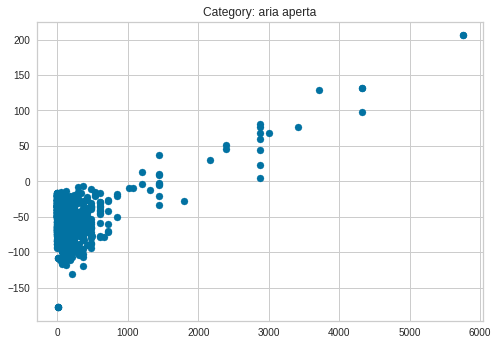

Data dimension: (792, 1624)


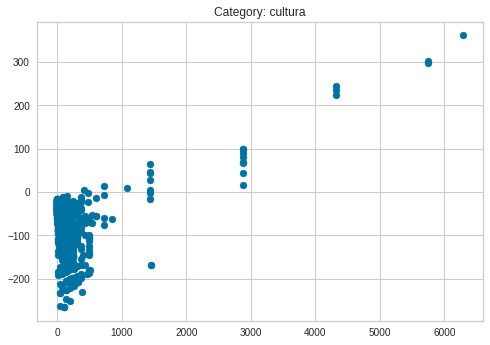

Data dimension: (1191, 2082)


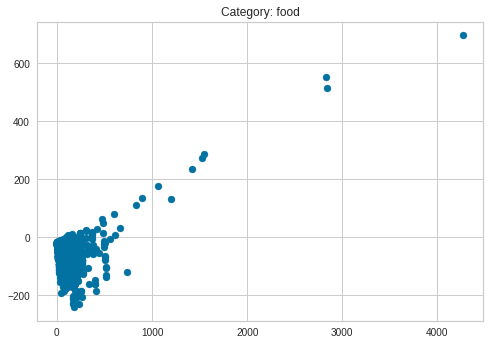

Data dimension: (326, 666)


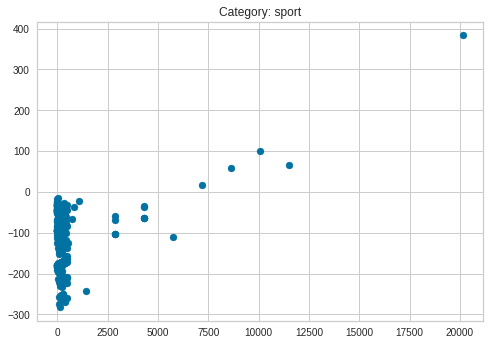

Data dimension: (522, 962)


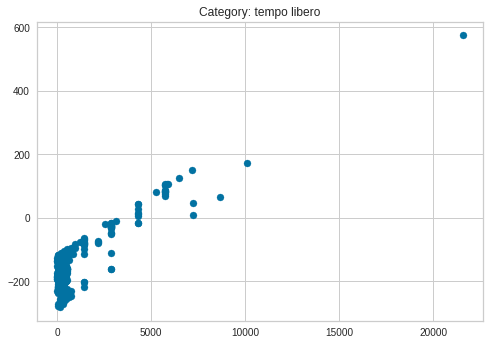

Data dimension: (934, 2119)


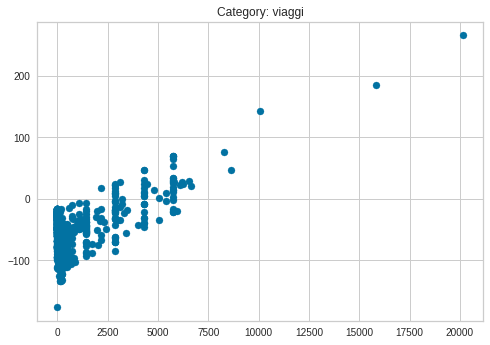

In [ ]:
svd_dict_tfidf = plot_with_SVD(X, categories, tfidf_dict)

Data dimension: (738, 770)


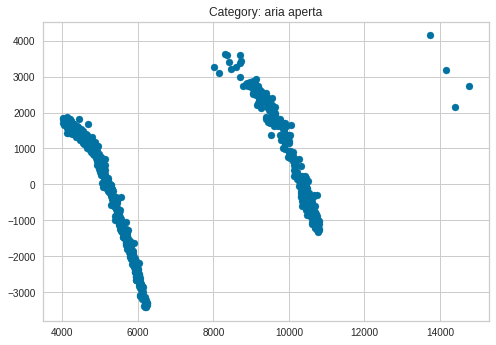

Data dimension: (792, 770)


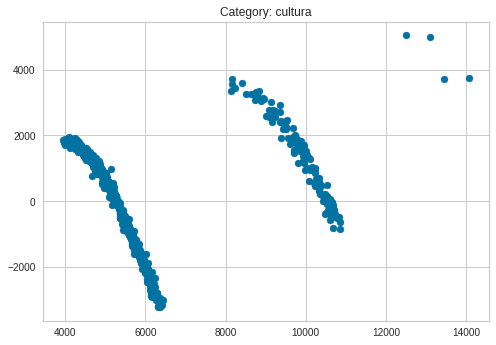

Data dimension: (1191, 770)


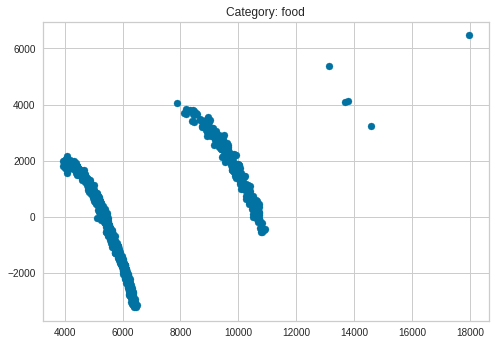

Data dimension: (326, 770)


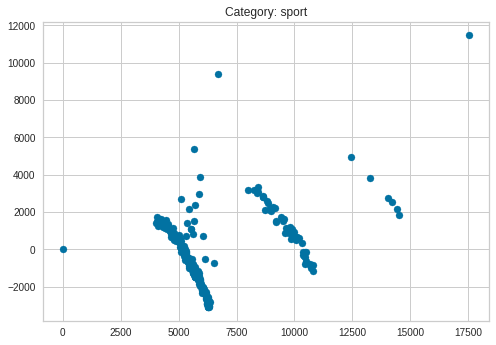

Data dimension: (522, 770)


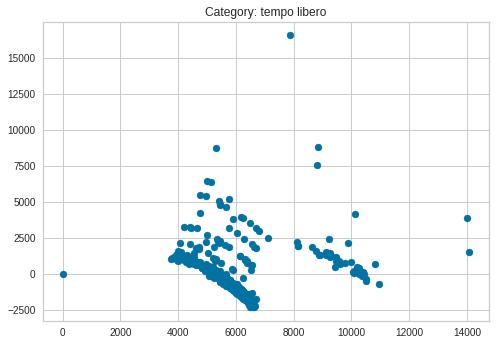

Data dimension: (934, 770)


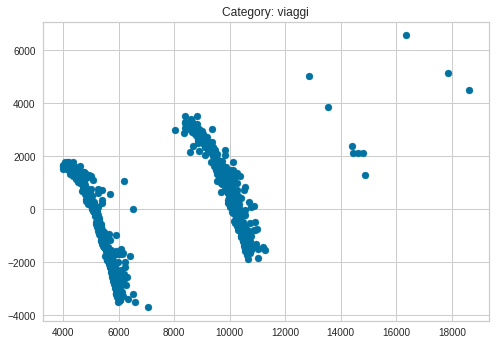

In [ ]:
svd_dict_embeddings = plot_with_SVD(X, categories, embeddings)

In [ ]:
#Plot results
def plotKMeans(label:np.ndarray, df:pd.DataFrame, category:str):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters for {}'.format(len(u_labels), category))
  plt.legend()
  plt.show()

In [ ]:
def kmeans_tests(data:pd.DataFrame, category:str, svd_dict:dict, clusters_number:int=10, steps:int=1):
  inertia = []
  times = dict() #{k:time_needed}
  K = range(2,clusters_number,steps) 
  for k in K:
      #Fit 
      start = time.time()
      kmeanModel = KMeans(n_clusters=k)
      kmeans = kmeanModel.fit(data)
      time_needed = time.time() - start
      times[k] = time_needed
      #Elbow
      inertia.append(kmeanModel.inertia_)
      #Clusters
      label = kmeans.predict(data)
      plotKMeans(label, svd_dict[category], category)
  return inertia, times, K

In [ ]:
def elbow_and_statistics(inertia:list, times:dict, K:list):
  #Elbow
  plt.figure(figsize=(10,3))
  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()
  print("\n")
  #Inertia
  for k,value in zip(K, inertia):
    print("Inertia for {} clusters is: {}".format(k,value))
  print("\n")
  #Times needed
  for k,v in times.items():
    print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

In [ ]:
def elbow_visualizer(data:pd.DataFrame, k:int):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=k)
  visualizer.fit(data)        
  visualizer.show() 

In [ ]:
def kmeans_computation(data:pd.DataFrame, description_dict:dict, categories:list, svd:dict, k:int, visualizer:bool=False):
  assert type(categories)==list, "Expected list as input not {}".format(type(categories))
  for c in categories:
    print("Category: {}".format(c))
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    if visualizer:
      #kmeans
      inertia, times, K = kmeans_tests(data_with_encodings, c, svd, k)
      # Elbow and inertia
      elbow_and_statistics(inertia, times, K)
    else:
      elbow_visualizer(data_with_encodings, k)  

Category: aria aperta


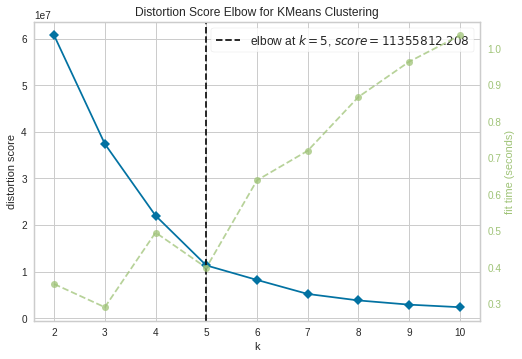

Category: cultura


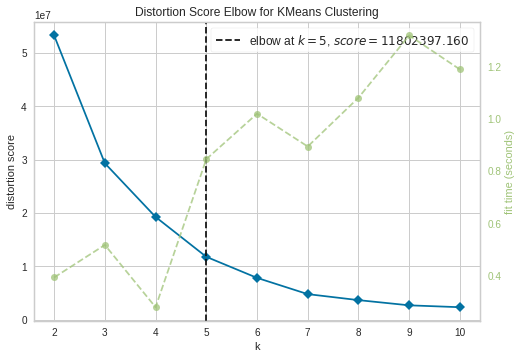

Category: food


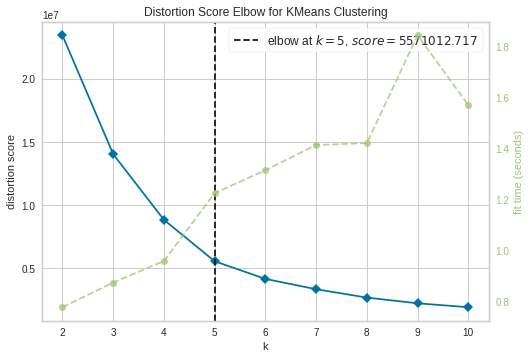

Category: sport


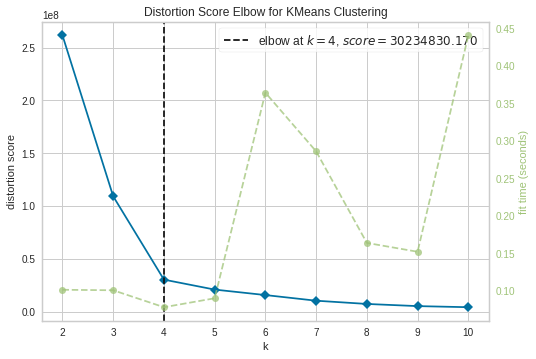

Category: tempo libero


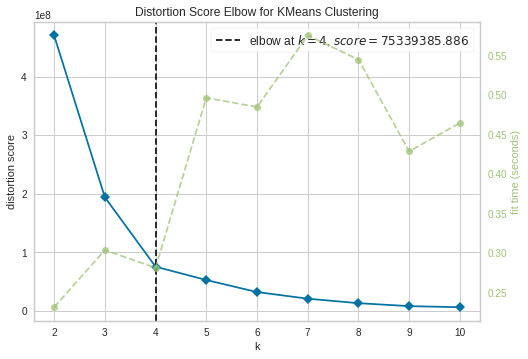

Category: viaggi


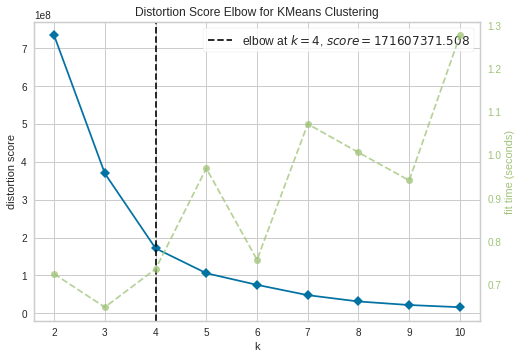

In [ ]:
kmeans_computation(X, tfidf_dict, categories, svd_dict_tfidf, 10)

Category: aria aperta


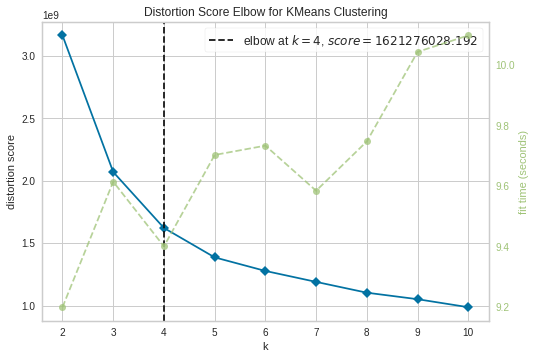

Category: cultura


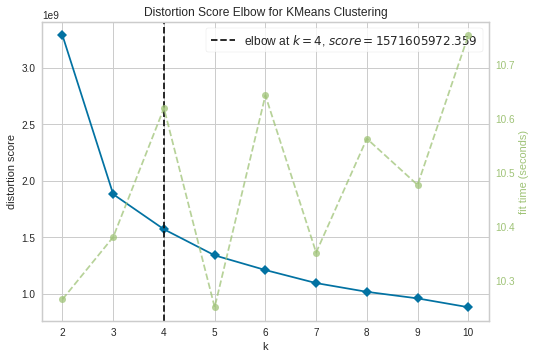

Category: food


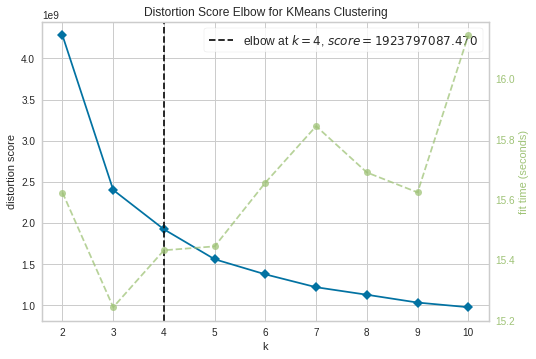

Category: sport


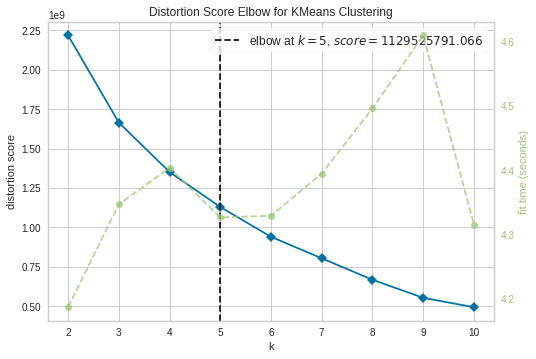

Category: tempo libero


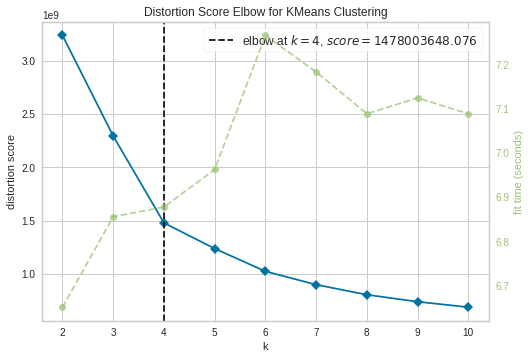

Category: viaggi


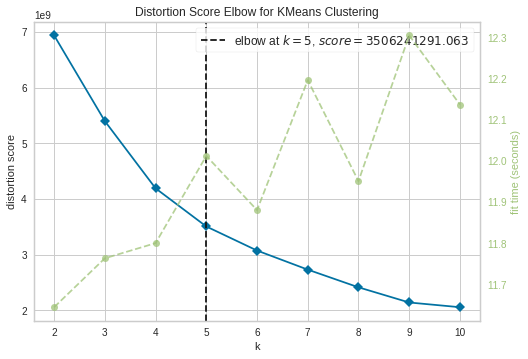

In [ ]:
kmeans_computation(X, embeddings, categories, svd_dict_embeddings, 10)

In [ ]:
optimal_number_clusters = {"aria aperta":4, "cultura":4, "food":4, "sport":3, "tempo libero":3, "viaggi":5}
#optimal_number_clusters = {"aria aperta":7, "cultura":7, "food":7, "sport":7, "tempo libero":7, "viaggi":7}
#optimal_number_clusters = {"aria aperta":10, "cultura":10, "food":10, "sport":10, "tempo libero":10, "viaggi":10}

In [ ]:
# Return list of ranking for clusters ordered in ascending manner by number of posts
# the list has in i-th position the ranking of the i-th cluster 
def rank_clusters_in_categories(counts:pd.DataFrame, 
                                category:str):
  counts.sort_values(inplace=True)
  ordered_clusters = [x[0] for x in counts.index]
  ranking = [0 for x in ordered_clusters]
  for idx, r in enumerate(ordered_clusters):
    ranking[r] = idx + 1
  return ranking

# Compute the clusters for each category
def compute_clusters(data:pd.DataFrame, optimal_number_clusters:dict, description_dict:dict):
  kmeans_dict = dict()
  ranking_clusters_per_category = dict()
  for k,v in optimal_number_clusters.items():
    kmeanModel = KMeans(n_clusters=v)
    print("Category '{}' has {} clusters".format(k,v))
    data_category = data[data[k]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[k], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    data_with_encodings = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)

    kmeans = kmeanModel.fit(data_with_encodings.values)
    kmeans_dict[k] = kmeans
    #print number of posts in each cluster
    labels = kmeans.labels_
    count_elem_per_cluster = pd.DataFrame(labels).value_counts()
    ranking_clusters_per_category[k] = rank_clusters_in_categories(count_elem_per_cluster, k)
    print(count_elem_per_cluster)
    print()
  #print(ranking_clusters_per_category)
  return kmeans_dict, ranking_clusters_per_category

In [ ]:
kmeans_tfidf_dict, ranking_clusters_per_category_tfidf = compute_clusters(X, optimal_number_clusters, tfidf_dict)

Category 'aria aperta' has 4 clusters
3      6
1     13
2    152
0    567
dtype: int64

Category 'cultura' has 4 clusters
1      6
3      8
2     15
0    763
dtype: int64

Category 'food' has 4 clusters
1      3
3      9
0    534
2    645
dtype: int64

Category 'sport' has 3 clusters
1      3
2     13
0    310
dtype: int64

Category 'tempo libero' has 3 clusters
2      1
1     48
0    473
dtype: int64

Category 'viaggi' has 5 clusters
3      2
1     36
4     62
0     72
2    762
dtype: int64



In [ ]:
print(ranking_clusters_per_category_tfidf)

{'aria aperta': [4, 2, 3, 1], 'cultura': [4, 1, 3, 2], 'food': [3, 1, 4, 2], 'sport': [3, 1, 2], 'tempo libero': [3, 2, 1], 'viaggi': [4, 2, 5, 1, 3]}


In [ ]:
kmeans_embeddings_dict, ranking_clusters_per_category_embeddings = compute_clusters(X, optimal_number_clusters, embeddings)

Category 'aria aperta' has 4 clusters
2    106
1    117
3    254
0    261
dtype: int64

Category 'cultura' has 4 clusters
1    136
2    210
3    217
0    229
dtype: int64

Category 'food' has 4 clusters
2    207
0    223
3    377
1    384
dtype: int64

Category 'sport' has 3 clusters
2      5
1     56
0    265
dtype: int64

Category 'tempo libero' has 3 clusters
0     45
2    178
1    299
dtype: int64

Category 'viaggi' has 5 clusters
0     57
4    147
2    172
3    272
1    286
dtype: int64



In [ ]:
print(ranking_clusters_per_category_embeddings)

{'aria aperta': [4, 2, 1, 3], 'cultura': [4, 1, 2, 3], 'food': [2, 4, 1, 3], 'sport': [3, 2, 1], 'tempo libero': [1, 3, 2], 'viaggi': [1, 5, 3, 4, 2]}


In [ ]:
from itertools import groupby
import math

# Used in the heap
def get_similarity(t:tuple):
  return t[1]

# get the ranking of the categories for the target user 
# the first category is the one with more posts
# return: list of tuples (category, #posts)
def ranking_target(target_categories:dict):
  scores_clusters = [(cat, len(s)) for cat, cluster in target_categories.items() \
                     for s in cluster.values()]
  scores_categories = []
  for i, g in groupby(sorted(scores_clusters), key=lambda x: x[0]):
      scores_categories.append([i, sum(v[1] for v in g)])
  scores_categories.sort(key=lambda x: x[1], reverse=True)
  #print(scores_categories)
  return scores_categories

# retrieve the score for a certain category
def get_score_category(ranking:list, 
                       category:str):
  score = 0
  for r in ranking:
    if r[0] == category:
      score = r[1]
  return score

# retrieve ranking of a category
def get_ranking_category(ranking:list, 
                         category:str):
  for i,r in enumerate(ranking):
    if r[0] == category:
      return i+1
  #category not in ranking -> target user has not posted in such category
  return (len(ranking))

# compute the distance between two users, given a category and the ranking of the clusters for such category
def get_cluster_distance(user_clusters:dict, 
                         target_clusters:dict, 
                         ranking:list):
  distance = 0
  if not target_clusters: #target has no clusters for this category
    distance = sum([len(cluster) for cluster in user_clusters.values()])
  elif not user_clusters:
    distance = sum([len(cluster) for cluster in target_clusters.values()])
  else:
    #take all the clusters names
    target_keys_set = set(target_clusters.keys())
    user_keys_set = set(user_clusters.keys())
    keys_set = target_keys_set | user_keys_set
    #compute distance for each cluster of the category and update total distance
    for k in keys_set:
      target_clusters_k = 0
      user_clusters_k = 0
      if k in target_keys_set:
        target_clusters_k = len(target_clusters[k])
      if k in user_keys_set:
        user_clusters_k = len(user_clusters[k])
      #distance is divided by the total number of posts and the logarith of the ranking of the cluster
      distance += abs(user_clusters_k-target_clusters_k)/((user_clusters_k+target_clusters_k)*math.log2(ranking[k]+1))
  return distance

# Compute the distance between the target user and all the other users
# and return the most similar ones (the number can be specified using top) 
def distance(target_user:int, 
             partitions_users:dict,
             ranking_clusters_per_category:dict, 
             top:int=5):
  if target_user not in partitions_users:
    print("This ({}) user does not exist".format(target_user))
    return
  heap = []
  heapq.heapify(heap)
  #get the ranking of the categories for the user
  ranking = ranking_target(partitions_users[target_user])
  for user,partitions in partitions_users.items():
    if user == target_user:
      continue 
    distance = 0
    for c in categories:
      #target_category_score = get_score_category(ranking, c)
      ranking_clusters = ranking_clusters_per_category[c]
      target_category_ranking = get_ranking_category(ranking, c)
      user_category_clusters = {}
      if c in partitions:
        user_category_clusters = partitions[c]
      # check if target user has clusters for this category
      target_category_clusters = {} 
      if c in partitions_users[target_user]:
        target_category_clusters = partitions_users[target_user][c]
      #compute distance for the actual category and update total distance
      distance_category = get_cluster_distance(user_category_clusters,
                                               target_category_clusters,
                                               ranking_clusters)
      distance += distance_category / math.log2(target_category_ranking + 1)#* (len(categories)-target_category_ranking)
      #push in the heap
    heapq.heappush(heap, (user, distance))
  return heapq.nsmallest(top, heap, key=get_similarity) 

In [ ]:
def print_posts_user(user:int):
  print("Posts for user {}:".format(user))
  try:
    posts = df_schede[df_schede["userId"]==user]
  except:
    print("User does not exist")
  for _, p in posts.iterrows():
    print(p.description)
    print("-"*100)

def print_info_for_user(user:int, 
                        partition:dict):
  if user not in partition:
    print("This user does not exist")
    return
  print("Info about the clusters for the posts of user {}".format(user))
  partitions_categories = partition[user]
  for category,partitions in partitions_categories.items():
    print("Clusters for category {}: {}".format(category, len(partitions)))
    for cluster,array in partitions.items():
      print("#items in cluster {} for category {}: {}".format(cluster, category, len(array)))
    print()    

## Considering posts users wrote

In [ ]:
target_id = 129

In [ ]:
# Compute the distribution of the posts in the clusters for each user
# partitions = {user1: {c0:[post12, post45], c1:[post1], c2:[post5]}, user2:{c0:[], c1:[]}, etc}
def posts_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    users = data_category["userId"]
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    # add posts to the partitions
    for u,p,d in zip(users, posts_ids, data_post.iterrows()):
      user = u
      post = p
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      if user in partitions:
          #check if category c already exists for userId
          if c in partitions[user]:
            #check if cluster already exists for the category c of userId
            if cluster in partitions[user][c]:
              partitions[user][c][cluster].append(post)
            else:
              partitions[user][c][cluster] = [post]
          else:
            partitions[user][c] = dict()
            partitions[user][c][cluster] = [post]
      else:
        partitions[user] = dict()
        partitions[user][c] = dict()
        partitions[user][c][cluster] = [post]
  return partitions

In [ ]:
# partitions_by_user = posts_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_embeddings_dict,
#                                         embeddings)

In [ ]:
partitions_by_user = posts_in_partition(data_with_ids,
                                        categories,
                                        kmeans_tfidf_dict,
                                        tfidf_dict)

In [ ]:
print_info_for_user(target_id, partitions_by_user)

Info about the clusters for the posts of user 129
Clusters for category cultura: 1
#items in cluster 0 for category cultura: 10

Clusters for category food: 3
#items in cluster 0 for category food: 16
#items in cluster 3 for category food: 1
#items in cluster 2 for category food: 4

Clusters for category sport: 1
#items in cluster 0 for category sport: 6

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 12
#items in cluster 1 for category tempo libero: 1

Clusters for category viaggi: 1
#items in cluster 2 for category viaggi: 2



In [ ]:
#print_posts_user(target_id)

In [ ]:
# best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_embeddings)
# best_users_from_posts

In [ ]:
best_users_from_posts = distance(target_id, partitions_by_user, ranking_clusters_per_category_tfidf)
best_users_from_posts

[(176, 1.3878890375492143),
 (268, 1.7878698573490628),
 (314, 2.391244835628892),
 (468, 2.4267675796253423),
 (244, 2.5385217825694477)]

In [ ]:
for u in best_users_from_posts:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 176
Clusters for category cultura: 1
#items in cluster 0 for category cultura: 6

Clusters for category food: 2
#items in cluster 2 for category food: 3
#items in cluster 0 for category food: 3

Clusters for category sport: 1
#items in cluster 0 for category sport: 3

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 10
#items in cluster 1 for category tempo libero: 3

Clusters for category viaggi: 1
#items in cluster 2 for category viaggi: 2

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 268
Clusters for category cultura: 2
#items in cluster 0 for category cultura: 12
#items in cluster 2 for category cultura: 1

Clusters for category food: 2
#items in cluster 0 for category food: 6
#items in cluster 2 for category food: 2

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters f

## Considering the posts the users liked

In [ ]:
target_id = 129

In [ ]:
# Compute distribution of the likes in the clusters for each user
# partitions = {user1: {c0:[like1, like4], c1:[like6], c2:[like3]}, user2:{c0:[], c1:[]}, etc}
def likes_in_partition(data:pd.DataFrame, 
                       categories:list, 
                       kmeans_dict:dict,
                       description_dict:dict):
  partitions = dict()
  #build one category at a time
  for c in categories:
    data_category = data[data[c]!=0]
    descriptions_encodings = pd.DataFrame(description_dict[c], index=data_category.index)
    data_category.drop(columns=categories, inplace=True)
    posts_ids = data_category["id"]
    data_post = pd.concat([data_category, descriptions_encodings], axis=1, ignore_index=True)
    #remove userId and posts' ids
    data_post = data_post.iloc[: , 2:] 
    for p,d in zip(posts_ids, data_post.iterrows()):
      post = p
      try:
        users_list = posts_with_likes.at[p] #error if p is not in posts_with_likes
      except:
        # no one liked the post -> skip it
        continue
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      for user in users_list:
        if user in partitions:
            #check if category c already exists for userId
            if c in partitions[user]:
              #check if cluster already exists for the category c of userId
              if cluster in partitions[user][c]:
                partitions[user][c][cluster].append(post)
              else:
                partitions[user][c][cluster] = [post]
            else:
              partitions[user][c] = dict()
              partitions[user][c][cluster] = [post]
        else:
          partitions[user] = dict()
          partitions[user][c] = dict()
          partitions[user][c][cluster] = [post]
  return partitions

In [ ]:
# partitions_by_user_likes = likes_in_partition(data_with_ids,
#                                         categories,
#                                         kmeans_embeddings_dict,
#                                         embeddings)

In [ ]:
partitions_by_user_likes = likes_in_partition(data_with_ids,
                                        categories,
                                        kmeans_tfidf_dict,
                                        tfidf_dict)

In [ ]:
print_info_for_user(target_id, partitions_by_user_likes)

Info about the clusters for the posts of user 129
Clusters for category aria aperta: 3
#items in cluster 0 for category aria aperta: 3
#items in cluster 1 for category aria aperta: 1
#items in cluster 2 for category aria aperta: 1

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 5

Clusters for category food: 2
#items in cluster 2 for category food: 2
#items in cluster 0 for category food: 4

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters for category tempo libero: 2
#items in cluster 0 for category tempo libero: 4
#items in cluster 1 for category tempo libero: 1

Clusters for category viaggi: 3
#items in cluster 2 for category viaggi: 3
#items in cluster 4 for category viaggi: 1
#items in cluster 1 for category viaggi: 1



In [ ]:
print_posts_user(target_id)

Posts for user 129:
Otranto, in Puglia, vanta il primato italiano di città più ad est dello stivale. Ad esso assegnerei un ulteriore riconoscimento relativo alle spiagge chiarissime, il mare limpido e la cultura e l’arte del luogo.
Storicamente fu un punto strategico di commercio, ma questo la rendeva ulteriormente vulnerabile a tutti gli attacchi provenienti da tutto l’Adriatico. Otranto è per questo una ex città fortificata con un borgo antico ancora circondato dalle mura perimetrali, robuste torri e un imponente castello.

Oltre alla antica storia, Otranto offre moltissimo dal punto di vista turistico. Molti sono i locali, i ristoranti vista mare e le passeggiate lungo il porto. 
Ma le bellezze di Otranto non finiscono qui, molto vicino alla città potrete trovare moltissimi scenari naturali, spiagge e mare impareggiabile.

Ecco per me le spiagge imperdibili:
📍Baia dei Turchi, che prende il suo nome dalla leggenda che racconta che qui sbarcarono i famigerati soldati Ottomani. La spia

In [ ]:
# best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_embeddings)
# best_users_from_likes

In [ ]:
best_users_from_likes = distance(target_id, partitions_by_user_likes, ranking_clusters_per_category_tfidf)
best_users_from_likes

[(399, 1.6046011049137252),
 (553, 1.6723095348512638),
 (429, 1.7495614523219167),
 (158, 1.8168088210656126),
 (150, 1.9135484130472404)]

In [ ]:
for u in best_users_from_likes:
  print_info_for_user(u[0], partitions_by_user)
  print("-"*100)

Info about the clusters for the posts of user 399
Clusters for category aria aperta: 4
#items in cluster 2 for category aria aperta: 4
#items in cluster 1 for category aria aperta: 1
#items in cluster 3 for category aria aperta: 1
#items in cluster 0 for category aria aperta: 5

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 14

Clusters for category food: 2
#items in cluster 0 for category food: 1
#items in cluster 2 for category food: 1

Clusters for category sport: 1
#items in cluster 0 for category sport: 2

Clusters for category tempo libero: 2
#items in cluster 1 for category tempo libero: 4
#items in cluster 0 for category tempo libero: 13

----------------------------------------------------------------------------------------------------
Info about the clusters for the posts of user 553
Clusters for category aria aperta: 1
#items in cluster 0 for category aria aperta: 9

Clusters for category cultura: 1
#items in cluster 0 for category cultura: 4

C

## Show recommendations

In [ ]:
def print_single_result(data:pd.DataFrame, 
                        recommended_user):
  assert type(recommended_user) == tuple, "Use print_results for multiple users"
  posts = data[data["userId"]==recommended_user[0]]
  print("User: {}".format(recommended_user[0]))
  for _, p in posts.iterrows():
    print("Post:")
    print(p.description)
  print("-"*100)

def print_results(data:pd.DataFrame, 
                  recommended_users):
  assert type(recommended_users)==list, "Use print_single_result for single user"
  for u in recommended_users:
    posts = data[data["userId"]==u[0]]
    print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      print("Post:")
      print(p.description)
    print("-"*100)

In [ ]:
#print_single_result(df_schede, best_users_from_posts[0])

In [ ]:
#print_results(df_schede, best_users_from_posts)

In [ ]:
#print_single_result(df_schede, best_users_from_likes[0])

In [ ]:
#print_results(df_schede, best_users_from_likes)

Choose the posts from the best users:


1.   Consider posts that most similar users liked
2.   Consider posts with more likes

1) Get the posts that most similar users liked and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important)

In [ ]:
# Consider posts that most similar users liked
# the score for a posts depends on the number of likes and the ranking of the users that liked it
def score_post(user_list:list, recommended_users:list):
  score = 0
  for u in user_list:
    rec_users = [x[0] for x in recommended_users]
    if u in rec_users:
      score += len(recommended_users) - rec_users.index(u) +1
    else:
      score += 1
  return score

def get_posts_similar_users_liked(data:pd.DataFrame, 
                                  users_with_likes:pd.DataFrame, 
                                  recommended_users:list):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  liked_posts = dict()
  for u in recommended_users:
    try:
      posts = users_with_likes.at[u[0]] #liked posts for u
      for id in posts:
        likes = posts_with_likes.at[id] #users who liked this post
        if id in liked_posts:
          # we already retrieve the likes for this post
          continue
        else:
          liked_posts[id] = (u[0], likes)
    except:
      print("User {} did not like any post".format(u[0]))
      #print("-"*100)
      continue
  posts_scores = []
  for p_id,l in liked_posts.items():
    posts_scores.append((l[0], p_id, score_post(l[1], recommended_users), len(l[1])))
  ranking = sorted(posts_scores, key=lambda tup: tup[2], reverse=True)
  #print("Number of recommended posts: {}\nRecommended posts: {}".format(len(ranking), ranking))
  for idx,t in enumerate(ranking):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return ranking

In [ ]:
ranking_liked_posts = get_posts_similar_users_liked(df_schede, users_with_likes, best_users_from_posts)

User 244 did not like any post
1)Post 61c9994121c95d5d91092cc6 from user 176 with 3 likes and score 10
['“Che farai domani?”\n“Andrò a pranzo a Parigi “\nCOOOSAAAAA 😮\nEbbene sì, è possibile! Sarà sicuramente faticoso, ma la vista della Tour Eiffel ripagherà ogni fatica.\nParlando con una mia amica non sapeva cosa fare il giorno del suo compleanno e io le proposi un pranzo fuori, ma dove ? Vivendo a Roma i posti non mancano, ma volevamo qualcosa di particolare. Così le propongo un pranzo a Parigi. Andata e ritorno nella stessa giornata. \nAbbiamo controllato i voli e coincidevano perfettamente l’andata era la mattina molto presto alle 6:30 ed il ritorno alle 20:55. PERFETTO SI PARTE! \n\n🛫Preso il volto diretto per Parigi Beauvais atterriamo e prendiamo il pullman ( abbiamo acquistato precedentemente i biglietti online ) \nDiretto a Port Maillot ;Qui ci sono 2 opzioni\n• fare circa 3km a piedi, ma visto il poco tempo eviterei\n•🚇 meglio prendere la linea GIALLA1 in dir. CHÂTEAU DE VICE

2) Get the posts from the most similar users and rank them considering the number of likes, weighted by importance of who liked the posts (likes from users that are in the recommendation lists are more important)

In [ ]:
# Consider posts, from the recommended users, with more likes
def get_number_likes(post_likes:tuple):
  return post_likes[2]

# the score for a posts depends on the number of likes and the ranking of the users that liked it
def score_post(user_list:list, recommended_users:list):
  score = 0
  for u in user_list:
    if u in recommended_users:
      score += len(recommended_users) - recommended_users.index(u) +1
    else:
      score += 1
  return score

def get_posts_with_more_likes(data:pd.DataFrame, 
                              posts_with_likes:pd.DataFrame, 
                              recommended_users:list, 
                              top:int=10):
  assert type(recommended_users)==list, "recommeded_users should be a list of users'ids"
  heap = []
  heapq.heapify(heap)
  recommended_users_list = [u[0] for u in recommended_users]
  for u in recommended_users_list:
    try:
      posts = data[data["userId"]==u]
    except:
      print("User {} did not post anything".format(u))
      print("-"*100)
      continue
    #print("User: {}".format(u[0]))
    for _, p in posts.iterrows():
      id = p.id
      try:
        users_likes = posts_with_likes.at[id]
        number_of_likes = len(users_likes)
        score_likes = score_post(users_likes, recommended_users_list)
      except:
        #print("Post {} has no likes".format(id))
        continue
      heapq.heappush(heap, (u, id, score_likes, number_of_likes))
  top_list = heapq.nlargest(top, heap, key=get_number_likes) 
  #print best
  for idx,t in enumerate(top_list):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return top_list

In [ ]:
ranking_posts = get_posts_with_more_likes(df_schede, posts_with_likes, best_users_from_posts)

1)Post 6170706029421c39e7cd0639 from user 314 with 2 likes and score 7
['La spiaggia di fontane bianche si trova poco sotto Siracusa, è tra le più belle della Sicilia, le acque, infatti, sembrano ancora più chiare per effetto della sabbia bianca che sul fondale è attraversata da varie sorgenti di acqua dolce, da questo deriva il nome. La spiaggia è una lunga lingua di terra che abbraccia il piccolo golfo. Conviene affittare un ombrellone e qualche lettino, visto che sarà quasi sempre piena; ma il luogo restituisce comunque una profonda tranquillità, quasi caraibica. Sul lato sud ci sono parecchi scogli, dove, con una maschera sarà possibile osservare molti pesci e altri piccoli animali marini. Tappa obbligata per un viaggio nella Sicilia Orientale.']
----------------------------------------------------------------------------------------------------
2)Post 61a9d9157e9cec6a98498cfa from user 468 with 2 likes and score 7
['Billund è una piccola cittadina Danese nella penisola dello Jutla

In [ ]:
ranking_liked_posts[0]
#ranking_posts

(176, '61c9994121c95d5d91092cc6', 10, 3)

In [ ]:
def hybrid_recommender(data, *recommended_posts_lists):
  recommendations = []
  for r in recommended_posts_lists:
    recommendations += r[0]
  rec = sorted(recommendations, key=lambda tup: tup[2], reverse=True)
  for idx,t in enumerate(rec):
    print("{})Post {} from user {} with {} likes and score {}".format(idx+1, t[1], t[0], t[3], t[2]))
    p = data[data["id"]==t[1]]
    print(p.description.values)
    print("-"*100)
  return recommendations

In [ ]:
hybrid_ranking = hybrid_recommender(df_schede, (ranking_liked_posts, ranking_posts))

1)Post 61c9994121c95d5d91092cc6 from user 176 with 3 likes and score 10
['“Che farai domani?”\n“Andrò a pranzo a Parigi “\nCOOOSAAAAA 😮\nEbbene sì, è possibile! Sarà sicuramente faticoso, ma la vista della Tour Eiffel ripagherà ogni fatica.\nParlando con una mia amica non sapeva cosa fare il giorno del suo compleanno e io le proposi un pranzo fuori, ma dove ? Vivendo a Roma i posti non mancano, ma volevamo qualcosa di particolare. Così le propongo un pranzo a Parigi. Andata e ritorno nella stessa giornata. \nAbbiamo controllato i voli e coincidevano perfettamente l’andata era la mattina molto presto alle 6:30 ed il ritorno alle 20:55. PERFETTO SI PARTE! \n\n🛫Preso il volto diretto per Parigi Beauvais atterriamo e prendiamo il pullman ( abbiamo acquistato precedentemente i biglietti online ) \nDiretto a Port Maillot ;Qui ci sono 2 opzioni\n• fare circa 3km a piedi, ma visto il poco tempo eviterei\n•🚇 meglio prendere la linea GIALLA1 in dir. CHÂTEAU DE VICENNES e scendere a FRANKILN D.RO

# Method \#3: NCF

<h3>Neural Collaborative Filtering</h3>

## R matrix

In [ ]:
R = pd.DataFrame(columns=posts.values, index= users.values)
R

,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,61defcbe11b3bf4d3185a6e2,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Populate the rating matrix
for u in users_with_likes.index:
  posts_u = users_with_likes.loc[u]
  likes = dict()
  for p in posts_u:
    likes[p] = 1
  R.loc[u] = pd.Series(likes)

In [ ]:
R

,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,61defcbe11b3bf4d3185a6e2,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
606,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
R.count().sum()

1473

In [ ]:
R = R.reset_index()
R.rename(columns = {'index':'userId'}, inplace = True)
R

,userId,62355f98272ae5672fbc3ac7,620aa536ff8ae67f37cafb06,622c3b8ac992ca28f33c7f21,620a90c8ff8ae67f37caf97f,622c398cc992ca28f33c7edd,621128704f9d177c90f36d8a,6234aa65272ae5672fbc34c2,61f81896de25614ef958a724,6246deba30f1cc3afdc3bf06,...,61ead1f38e21a6510547457a,6206e0a3b1d0940f1225745b,620cd8ab25398565dadb5da2,61f56061306802033034caf9,62053dd7b1d0940f1225360c,620c32db25398565dadb5867,6213b3460f41f86438b07d9c,6207b9cdb1d0940f122580b7,61f6a3e3306802033034d576,620a132eb1d0940f1225a161
0,606,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
split = int(0.8*R.shape[0])
split

130

In [ ]:
# Train
df_train = R.head(split)
print("non-null data:", df_train[df_train>0].count().sum())
#df_train

# Test
test_split = R.shape[0] - split
df_test = R.tail(test_split)
print("non-null data:", df_test[df_test>0].count().sum())
#df_test

non-null data: 1603
non-null data: 33


## NCF by Microsoft's recommender library

In [ ]:
!pip install recommenders
!pip install tf-slim

  Using cached recommenders-1.1.0-py3-none-manylinux1_x86_64.whl (335 kB)
     |████████████████████████████████| 636 kB 9.3 MB/s 
  Using cached lightfm-1.16.tar.gz (310 kB)
     |████████████████████████████████| 197 kB 41.5 MB/s 
     |████████████████████████████████| 11.8 MB 38.8 MB/s 
  Using cached category_encoders-1.3.0-py2.py3-none-any.whl (61 kB)
  Using cached cornac-1.14.2-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
     |████████████████████████████████| 749 kB 35.7 MB/s 
     |████████████████████████████████| 10.9 MB 46.4 MB/s 
     |████████████████████████████████| 383 kB 39.8 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705390 sha256=0312390fa26b8022e899d7dfc8c0701ac97361b3d6431faf90824916b6c4eb46
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-

In [ ]:
import tensorflow as tf
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [ ]:
# map itemsIDs to integers
posts_dict = dict()
for i,p in enumerate(posts):
  posts_dict[i] = p

In [ ]:
len(posts_dict), len(users), len(posts_dict)*len(users)

(4647, 163, 757461)

In [ ]:
# data_list is a list of lists of three elements (["userID", "itemsID", "rating"]) for each couple (user, post)
data_list = []
for u in users:
  if u not in users_with_likes.index:
    for k in posts_dict.keys():
      data_list.append([u,k,0])
  else:
    u_likes = users_with_likes.at[u]
    for k,v in posts_dict.items():
      if v in u_likes:
        data_list.append([u,k,1])
      else:
        data_list.append([u,k,0])
len(data_list)

757461

In [ ]:
#build a dataframe from data_list
ncf_df = pd.DataFrame(data_list, columns=("userID", "itemID", "rating"))
zeros_ones = ncf_df["rating"].value_counts()
print("Number of zeros: {} and ones: {}".format(zeros_ones[0], zeros_ones[1]))
ncf_df

Number of zeros: 755988 and ones: 1473


,userID,itemID,rating
0,606,0,0
1,606,1,0
2,606,2,1
3,606,3,0
4,606,4,1
...,...,...,...
757456,615,4642,0
757457,615,4643,0
757458,615,4644,0
757459,615,4645,0


In [ ]:
#shuffle data e reset index
ncf_df = ncf_df.sample(frac=1).reset_index(drop=True)

In [ ]:
split = int(0.8*ncf_df.shape[0])
split

605968

In [ ]:
# Train data
df_train = ncf_df.head(split)
print("Train data length: {}".format(len(df_train)))
df_train.sort_values(by=['userID'], inplace=True)
df_train["rating"].value_counts()

Train data length: 605968


0    604764
1      1204
Name: rating, dtype: int64

In [ ]:
# Test data
test_split = ncf_df.shape[0] - split
df_test = ncf_df.tail(test_split)
df_test.sort_values(by=['userID'], inplace=True)
print("Test data length: {}".format(len(df_test)))
df_test["rating"].value_counts()

Test data length: 151493


0    151224
1       269
Name: rating, dtype: int64

In [ ]:
# the dataset object wants as input files containing the train and test sets (ordered by userID)
train_file = "./train.csv"
test_file = "./test.csv"
df_train.to_csv(train_file, index=False)
df_test.to_csv(test_file, index=False)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605968 entries, 260183 to 558637
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   userID  605968 non-null  int64
 1   itemID  605968 non-null  int64
 2   rating  605968 non-null  int64
dtypes: int64(3)
memory usage: 18.5 MB


In [ ]:
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 50
BATCH_SIZE = 32

SEED = 42

In [ ]:
from recommenders.datasets.python_splitters import python_random_split

In [ ]:
train, test = python_random_split(ncf_df, ratio=0.8)

In [ ]:
# userIDs and itemIDs in test set must be in train set
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [ ]:
train.sort_values(by=['userID'], inplace=True)
test.sort_values(by=['userID'], inplace=True)

In [ ]:
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
MOVIELENS_DATA_SIZE = '100k'
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)
train, test = python_chrono_split(df, 0.75)

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:00<00:00, 21.5kKB/s]


In [ ]:
train

,userID,itemID,rating,timestamp
59972,1,168,5.0,874965478
92487,1,172,5.0,874965478
74577,1,165,5.0,874965518
48214,1,156,4.0,874965556
22971,1,166,5.0,874965677
...,...,...,...,...
77956,943,94,4.0,888639929
99832,943,739,4.0,888639929
90134,943,2,5.0,888639953
87419,943,541,4.0,888639954


In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [ ]:
data_ncf = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./test_full.csv ...
100%|██████████| 163/163 [03:56<00:00,  1.45s/it]
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


ValueError: ignored

In [ ]:
model = NCF (
    n_users=data_ncf.n_users, 
    n_items=data_ncf.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data_ncf)

print("Took {} seconds for training.".format(train_time))

In [ ]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(df_train.itemID.unique())
    for user in df_train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(df_train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

In [ ]:
eval_map = map_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(df_test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

# Method \#4: Data2Vec

Paper -> https://arxiv.org/pdf/2202.03555.pdf

HF -> https://huggingface.co/docs/transformers/model_doc/data2vec#transformers.Data2VecTextModel

## Embedding data using Data2Vec

In [ ]:
!pip install -qqq -U sentence-transformers bert-extractive-summarizer sacremoses

     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 880 kB 18.6 MB/s 
     |████████████████████████████████| 1.3 MB 53.3 MB/s 


In [ ]:
from transformers import RobertaTokenizer, Data2VecTextModel
from transformers import BeitFeatureExtractor, Data2VecVisionModel
from summarizer.sbert import SBertSummarizer
import torch
from PIL import Image

from math import ceil
from tqdm import tqdm
from os import listdir
from os.path import isfile, join

In [ ]:
folder = "/content/drive/MyDrive/Tesi/images_small"
images = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f))]
len(images)

2511

In [ ]:
embeddings_vision_path = "/content/drive/MyDrive/Tesi/data2vec_vision_encoding"
embeddings_text_path = "/content/drive/MyDrive/Tesi/data2vec_text_encoding"

Descriptions are often too long to be fed to BERT -> two possible solutions (Memo: max number of tokens admitted is 514):


1.   after getting the tokens ids, split a description into chunks of length 510, add [CLS] and [SEP] tokens and feed the model with one chunk at the time. At the end compute the average of the chunks and keep just the [CLS] embedding;
2.  summarize texts down to 8 sentence and fed the summaries to the model (add truncation anyway because sometimes the limit is exceeded for a few tokens) 

 

In [ ]:
class MyTransformer():
    def __init__(
            self,
            pretrained_text_model: str = "facebook/data2vec-text-base",
            pretrained_vision_model: str = "facebook/data2vec-vision-base",
            summarizer = False,
            summarizer_model_name = 'distiluse-base-multilingual-cased-v1', 
            number_sentences=8,
            device: str = 'cpu'
    ):
        super().__init__()
        self.model_text = Data2VecTextModel.from_pretrained(pretrained_text_model)
        self.tokenizer = RobertaTokenizer.from_pretrained(pretrained_text_model)
        self.feature_extractor = BeitFeatureExtractor.from_pretrained(pretrained_vision_model)
        self.model_vision = Data2VecVisionModel.from_pretrained(pretrained_vision_model, add_pooling_layer=True)

        self.hidden_size = 768
        self.max_sequence_len = 512

        self.summarizer = summarizer
        if self.summarizer:
          self.model_summarizer = SBertSummarizer(summarizer_model_name)
          self.number_sentences = number_sentences

        self.model_text.to(device)
        print("Device used: {}".format(self.model_text.device))

    def add_special_tokens(self, tokens_ids):
      # add CLS (token_id is 101) and SEP (token_id is 102)
      ids = [101] + tokens_ids + [102]
      # add padding (token_id is 0)
      padding_length = self.max_sequence_len-len(ids)
      for i in range(padding_length):
        ids += [0]
      #print("\n padding_length: {} - len(tokens_ids): {}\nTokens_ids: {}".format(padding_length, len(ids), ids))
      return ids
    
    def get_summaries(self, df_documents):
      print("Summarizing the texts...")
      df_summarized = df_documents.apply(lambda article: self.model_summarizer(article, num_sentences=self.number_sentences))
      print("Summaries are ready!")
      return df_summarized.tolist()

    def encode_images(self, images):
      self.encodings_vision = []
      start = time.time()
      empty_images = 0
      for idx, i in tqdm(enumerate(images)):
        img = Image.open(i)
        try:
          inputs_vision = self.feature_extractor(img, return_tensors="pt")
        except:
          print("Image {} can not be processed, it will be replaced by an empty representation".format(i))
          empty_embedding = torch.zeros(self.hidden_size).to(device)
          self.encodings_vision.append(empty_embedding)
          empty_images += 1
          continue
        with torch.no_grad():
          outputs_vision = self.model_vision(**inputs_vision)
        vision_pooler_output = outputs_vision.pooler_output
        self.encodings_vision.append(vision_pooler_output[0])
      print("\nTime needed to encode {} images: {}s".format(len(images), time.time()-start))
      print("{} images were not processed".format(empty_images))

    def compute_embedding_text(self, tokens_ids):
      self.model_text.eval()
      self.seq_len_without_special_tokens = self.max_sequence_len - 2
      with torch.no_grad():
        if(len(tokens_ids) <= self.seq_len_without_special_tokens):
          tokens_ids = self.add_special_tokens(tokens_ids)
          context_embeddings = self.model_text(torch.tensor(tokens_ids)[None,:].to(device))[0]
        else:
          k = ceil(len(tokens_ids) / float(self.seq_len_without_special_tokens))
          chunks = np.array_split(tokens_ids, k)
          for i in range(len(chunks)):
            chunks[i] = self.add_special_tokens(chunks[i].tolist())
          chunks_tensor = torch.tensor(chunks[0])[None,:].to(device)
          context_embeddings_list = self.model_text(chunks_tensor)[0].to(device)
          for i in range(1, len(chunks)):
            chunks_tensor = torch.tensor(chunks[i])[None,:].to(device)
            context_embeddings_list = torch.cat((context_embeddings_list, self.model_text(chunks_tensor)[0]), 1)
          dim = context_embeddings_list.shape[-1]
          context_embeddings = context_embeddings_list.to(device)
        #compute the average of the vectors
        avg_embeddings = torch.sum(context_embeddings,1)[0]
      return avg_embeddings

    #return all the embeddings, with no distinction among the categories
    def encode_texts(self, docs):
      start = time.time()
      self.encodings_text = []
      if self.summarizer:
        docs = self.get_summaries(docs)
      for i, d in tqdm(enumerate(docs)): 
        if not d: #df_schede has null descriptions
          print("Document {} is an empty scheda".format(i))
          empty_embedding = torch.zeros(self.hidden_size).to(device)
          self.encodings_text.append(empty_embedding)
          continue
        t = self.tokenizer.tokenize(d)
        tokens_ids = self.tokenizer.convert_tokens_to_ids(t)
        self.encodings_text.append(self.compute_embedding_text(tokens_ids))
      print("\nTime needed to encode {} documents: {}s".format(len(docs), time.time()-start))
      #self.encodings = encodings

    def text_tokens_length(self, docs):
      res = 0
      N = len(docs) #number of docs
      max = 0
      longer_than_max_seq = 0
      for idx, d in tqdm(enumerate(docs)): 
        if not d: #df_schede has one null description
          N -= 1
          continue
        t = self.tokenizer.tokenize(d)
        length = len(t)
        res += length
        if length>max:
          max=length
        if length > self.seq_len_without_special_tokens:
          longer_than_max_seq += 1
      print("\nAverage number of tokens is {}\nMax number of tokens is {}\nNumber of sequences than have more than 510 tokens is {}".format(res/N, max, longer_than_max_seq))

In [ ]:
model = MyTransformer(device=device)
#model = MyTransformer(device=device, summarizer=True)
#model.text_tokens_length(df_schede.description)

Some weights of the model checkpoint at facebook/data2vec-text-base were not used when initializing Data2VecTextModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing Data2VecTextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecTextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Data2VecTextModel were not initialized from the model checkpoint at facebook/data2vec-text-base and are newly initialized: ['data2vec_text.pooler.dense.weight', 'data2vec_text.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

Device used: cuda:0


In [ ]:
model.encode_images(images)
embeddings_vision = model.encodings_vision

168it [02:42,  1.10it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-622520d335684f072b2e917a can not be processed, it will be replaced by an empty representation


272it [04:17,  1.02it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6241e96293595f4812e7fa38 can not be processed, it will be replaced by an empty representation


366it [05:39,  1.05it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6262d55775708f53a6626dda can not be processed, it will be replaced by an empty representation


408it [06:20,  1.00it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-62796d2e7959904ca6de01ec can not be processed, it will be replaced by an empty representation


411it [06:22,  1.19it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-627971b47959904ca6de04b6 can not be processed, it will be replaced by an empty representation


452it [06:59,  1.03s/it]

Image /content/drive/MyDrive/Tesi/images_small/cover-6290efb3b249c51405df44df can not be processed, it will be replaced by an empty representation


507it [07:48,  1.13it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-612e2967ac66033ff7906ede can not be processed, it will be replaced by an empty representation


512it [07:51,  1.33it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-613735f8f612585fc7b9f4d0 can not be processed, it will be replaced by an empty representation


518it [07:55,  1.40it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-613775010262334e87d8cbba can not be processed, it will be replaced by an empty representation


530it [08:03,  1.95it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6140a39f533f2f326b893d39 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6140a45a533f2f326b893e79 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6141c2a7533f2f326b89415b can not be processed, it will be replaced by an empty representation


532it [08:03,  3.00it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6141c2bc533f2f326b894252 can not be processed, it will be replaced by an empty representation


535it [08:04,  2.41it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6141c2d2533f2f326b89432d can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6149f0f000ce352eefee5838 can not be processed, it will be replaced by an empty representation


539it [08:05,  4.66it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6149f14100ce352eefee5cc5 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6149f16500ce352eefee5e8f can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6149f0d000ce352eefee5672 can not be processed, it will be replaced by an empty representation


542it [08:05,  6.03it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6149f16e00ce352eefee5eda can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6149f17400ce352eefee5f2d can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6149f1c800ce352eefee638d can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-614ae89f4198a77cbc08fb12 can not be processed, it will be replaced by an empty representation


544it [08:06,  5.82it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614ae8734198a77cbc08f95d can not be processed, it will be replaced by an empty representation


545it [08:07,  2.96it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614d9c77b3cc04136f19baad can not be processed, it will be replaced by an empty representation


549it [08:08,  3.54it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614d9c7db3cc04136f19baf4 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-614d9c60b3cc04136f19b962 can not be processed, it will be replaced by an empty representation


555it [08:12,  1.82it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616064a6eb3bf47494b8ebbc can not be processed, it will be replaced by an empty representation


556it [08:12,  2.22it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6160656beb3bf47494b8f6b7 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61606bfb811b972d300197a4 can not be processed, it will be replaced by an empty representation


558it [08:13,  3.21it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616064e7eb3bf47494b8ef29 can not be processed, it will be replaced by an empty representation


559it [08:13,  3.39it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616065beeb3bf47494b8fb09 can not be processed, it will be replaced by an empty representation


563it [08:16,  1.37it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169627027d0877f5c212b4c can not be processed, it will be replaced by an empty representation


565it [08:18,  1.48it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169627827d0877f5c212bdf can not be processed, it will be replaced by an empty representation


569it [08:18,  3.09it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616962be27d0877f5c212fa9 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169634c27d0877f5c213735 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616962f827d0877f5c2132a7 can not be processed, it will be replaced by an empty representation


572it [08:18,  4.60it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169635127d0877f5c213773 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169636527d0877f5c213897 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616963c327d0877f5c213ddb can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616963c827d0877f5c213e1d can not be processed, it will be replaced by an empty representation


574it [08:19,  5.05it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169635727d0877f5c2137ba can not be processed, it will be replaced by an empty representation


577it [08:20,  2.75it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616963ce27d0877f5c213e6a can not be processed, it will be replaced by an empty representation


578it [08:21,  2.11it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61697c8627d0877f5c214e11 can not be processed, it will be replaced by an empty representation


592it [08:29,  3.37it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-617284cde22ccc1544be0285 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6172900ce22ccc1544be05b4 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61728fffe22ccc1544be053f can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61729017e22ccc1544be061c can not be processed, it will be replaced by an empty representation


594it [08:30,  2.26it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6172dbc872b6f336088b9509 can not be processed, it will be replaced by an empty representation


597it [08:32,  2.02it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6172dbf572b6f336088b96c9 can not be processed, it will be replaced by an empty representation


621it [08:50,  1.99it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-618cc13aa94fb74965c128a2 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-618cc13ba94fb74965c128b8 can not be processed, it will be replaced by an empty representation


659it [09:20,  1.67it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-619e8b9d7cfa500b06189f50 can not be processed, it will be replaced by an empty representation


661it [09:21,  1.88it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-619e8b9e7cfa500b06189f64 can not be processed, it will be replaced by an empty representation


746it [10:35,  1.25it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61b47c3505808c2d13e1df93 can not be processed, it will be replaced by an empty representation


794it [11:16,  1.28it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c4e8dcad15dc51e7fa1076 can not be processed, it will be replaced by an empty representation


878it [12:27,  1.18it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61df085a11b3bf4d3185a7ca can not be processed, it will be replaced by an empty representation


881it [12:28,  1.39it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61df02a711b3bf4d3185a742 can not be processed, it will be replaced by an empty representation


915it [12:56,  1.28it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e6fce975da361a4e80c346 can not be processed, it will be replaced by an empty representation


919it [12:57,  2.02it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e7d38575da361a4e80c671 can not be processed, it will be replaced by an empty representation


930it [13:07,  1.18it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61ed49cb8e21a6510547516f can not be processed, it will be replaced by an empty representation


937it [13:12,  1.33it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61ee96cf8e21a65105475fd5 can not be processed, it will be replaced by an empty representation


959it [13:31,  1.15it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61f44607306802033034c406 can not be processed, it will be replaced by an empty representation


989it [13:59,  1.13s/it]

Image /content/drive/MyDrive/Tesi/images_small/cover-61fd4fa975551f4dc5a6baaf can not be processed, it will be replaced by an empty representation


1084it [15:17,  1.32it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6213cee88398a23a0a2ec63a can not be processed, it will be replaced by an empty representation


1162it [16:22,  1.49it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-62250fa335684f072b2e8f25 can not be processed, it will be replaced by an empty representation


1324it [18:39,  1.54it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-624c8f99f1ecd329b3ed9191 can not be processed, it will be replaced by an empty representation


1510it [21:25,  1.24it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-612e30f4ac66033ff7907204 can not be processed, it will be replaced by an empty representation


1513it [21:27,  1.30it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61373672f612585fc7b9f80d can not be processed, it will be replaced by an empty representation


1515it [21:28,  1.63it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61373697f612585fc7b9f8f5 can not be processed, it will be replaced by an empty representation


1519it [21:29,  2.69it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61388958d8f3682bc5f4e1bc can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6138894dd8f3682bc5f4e16a can not be processed, it will be replaced by an empty representation


1530it [21:36,  2.23it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6140a349533f2f326b89396e can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6140a3ac533f2f326b893dde can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6140a34d533f2f326b8939ae can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6141c264533f2f326b893ea1 can not be processed, it will be replaced by an empty representation


1532it [21:36,  3.18it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6141c2b3533f2f326b8941d8 can not be processed, it will be replaced by an empty representation


1536it [21:37,  4.12it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6149f1d300ce352eefee6430 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-614ae8ab4198a77cbc08fb95 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-614ae8794198a77cbc08f9a2 can not be processed, it will be replaced by an empty representation


1539it [21:38,  3.54it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614d9bf2b3cc04136f19b466 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-614d9c0db3cc04136f19b576 can not be processed, it will be replaced by an empty representation


1542it [21:40,  2.12it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614d9c41b3cc04136f19b7d4 can not be processed, it will be replaced by an empty representation


1548it [21:44,  2.18it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6160658eeb3bf47494b8f8a8 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61606501eb3bf47494b8f0d1 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616065a0eb3bf47494b8f996 can not be processed, it will be replaced by an empty representation


1551it [21:44,  3.61it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61606650eb3bf47494b90406 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6160663eeb3bf47494b902ff can not be processed, it will be replaced by an empty representation


1555it [21:47,  2.04it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61606658eb3bf47494b9045d can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616565bf2efc02402cc91998 can not be processed, it will be replaced by an empty representation


1561it [21:49,  3.48it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616565ca2efc02402cc919e1 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169622f27d0877f5c212855 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616569672efc02402cc9202d can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169624827d0877f5c212957 can not be processed, it will be replaced by an empty representation


1564it [21:49,  5.42it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169629b27d0877f5c212de1 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616962ee27d0877f5c21322c can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169630c27d0877f5c2133db can not be processed, it will be replaced by an empty representation


1568it [21:49,  7.52it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169631527d0877f5c213462 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169637927d0877f5c2139bc can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169639b27d0877f5c213b56 can not be processed, it will be replaced by an empty representation


1570it [21:50,  4.16it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616963e327d0877f5c213f5f can not be processed, it will be replaced by an empty representation


1574it [21:53,  1.90it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616963ea27d0877f5c213fb7 can not be processed, it will be replaced by an empty representation


1585it [22:01,  1.30it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6172900ae22ccc1544be05a7 can not be processed, it will be replaced by an empty representation


1620it [22:29,  1.62it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61891bd8de2f885f7e6a0c95 can not be processed, it will be replaced by an empty representation


1753it [24:28,  1.41it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c065966196de111d20fe59 can not be processed, it will be replaced by an empty representation


1756it [24:30,  1.61it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c06b116196de111d20ff9b can not be processed, it will be replaced by an empty representation


1759it [24:32,  1.46it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c0471e6196de111d20fbd0 can not be processed, it will be replaced by an empty representation


1783it [24:55,  1.05it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c4b3aead15dc51e7fa0fcc can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61c4ef20ad15dc51e7fa107b can not be processed, it will be replaced by an empty representation


1786it [24:56,  1.62it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c59a35ad15dc51e7fa1291 can not be processed, it will be replaced by an empty representation


1790it [24:59,  1.45it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c5b4b1ad15dc51e7fa15c8 can not be processed, it will be replaced by an empty representation


1805it [25:11,  1.08it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c9cdbc21c95d5d91092efb can not be processed, it will be replaced by an empty representation


1857it [25:55,  1.25it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61dd5cdf9c823e129b1f2a90 can not be processed, it will be replaced by an empty representation


1876it [26:09,  1.62it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e1734602eda64de31b0112 can not be processed, it will be replaced by an empty representation


1885it [26:16,  1.70it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e350b6b426ef5d736ac3d4 can not be processed, it will be replaced by an empty representation


1892it [26:22,  1.15it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e6f73f75da361a4e80c28c can not be processed, it will be replaced by an empty representation


1896it [26:24,  1.77it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61e6f37275da361a4e80c1d1 can not be processed, it will be replaced by an empty representation


1914it [26:40,  1.05s/it]

Image /content/drive/MyDrive/Tesi/images_small/cover-61ed49cb8e21a65105475171 can not be processed, it will be replaced by an empty representation


1923it [26:48,  1.16it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61f014f8ec0942668ad31a93 can not be processed, it will be replaced by an empty representation


1971it [27:30,  1.17it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61fd39d875551f4dc5a6b8b8 can not be processed, it will be replaced by an empty representation


1983it [27:40,  1.15it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6200de1b8e7e9472f4ed643b can not be processed, it will be replaced by an empty representation


1985it [27:40,  1.53it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6200dffb8e7e9472f4ed68c4 can not be processed, it will be replaced by an empty representation


2020it [28:08,  1.30it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-612e3223ac66033ff79072f2 can not be processed, it will be replaced by an empty representation


2026it [28:11,  2.38it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61374cf4f612585fc7ba0cb2 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6137369bf612585fc7b9f912 can not be processed, it will be replaced by an empty representation


2030it [28:13,  2.79it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-613775080262334e87d8cbea can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6137360df612585fc7b9f547 can not be processed, it will be replaced by an empty representation


2047it [28:25,  2.08it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6141d350533f2f326b8943d0 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6141c824533f2f326b8943a1 can not be processed, it will be replaced by an empty representation


2048it [28:25,  2.54it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6140a356533f2f326b893a02 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6141c29c533f2f326b8940df can not be processed, it will be replaced by an empty representation


2052it [28:27,  2.11it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6149f1bd00ce352eefee62ea can not be processed, it will be replaced by an empty representation


2053it [28:27,  2.49it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-614ae85e4198a77cbc08f87d can not be processed, it will be replaced by an empty representation


2054it [28:27,  2.78it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6149f11700ce352eefee5a4b can not be processed, it will be replaced by an empty representation


2057it [28:28,  3.08it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616064f2eb3bf47494b8efda can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616065b9eb3bf47494b8faca can not be processed, it will be replaced by an empty representation


2059it [28:29,  4.22it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616064d2eb3bf47494b8edfe can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61606580eb3bf47494b8f801 can not be processed, it will be replaced by an empty representation


2062it [28:30,  4.06it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61606634eb3bf47494b90280 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61606663eb3bf47494b90507 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616962d827d0877f5c213113 can not be processed, it will be replaced by an empty representation


2064it [28:30,  4.71it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61606bee811b972d300196bf can not be processed, it will be replaced by an empty representation


2065it [28:30,  3.69it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169632b27d0877f5c213563 can not be processed, it will be replaced by an empty representation


2068it [28:31,  5.61it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616963aa27d0877f5c213c44 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-616963d227d0877f5c213ea8 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-6169640c27d0877f5c2141ad can not be processed, it will be replaced by an empty representation


2069it [28:31,  5.13it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-616963b127d0877f5c213ca1 can not be processed, it will be replaced by an empty representation


2075it [28:35,  1.93it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-6169655427d0877f5c21487f can not be processed, it will be replaced by an empty representation


2076it [28:36,  1.66it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61697bc227d0877f5c214bf7 can not be processed, it will be replaced by an empty representation


2088it [28:42,  3.32it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-617284cbe22ccc1544be027a can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61728ff0e22ccc1544be04b7 can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61729008e22ccc1544be059a can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61728fdfe22ccc1544be03fd can not be processed, it will be replaced by an empty representation
Image /content/drive/MyDrive/Tesi/images_small/cover-61729023e22ccc1544be068e can not be processed, it will be replaced by an empty representation


2092it [28:43,  2.73it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61729013e22ccc1544be05de can not be processed, it will be replaced by an empty representation


2116it [29:05,  1.36it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-618917d5de2f885f7e6a0c59 can not be processed, it will be replaced by an empty representation


2166it [29:47,  1.50it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61a0cc0f0783552ab94e1831 can not be processed, it will be replaced by an empty representation


2254it [31:00,  1.63it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61b7b55c2e1ccf5f8295465d can not be processed, it will be replaced by an empty representation


2289it [31:30,  1.08it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c5afa0ad15dc51e7fa146c can not be processed, it will be replaced by an empty representation


2292it [31:31,  1.35it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61c5c239ad15dc51e7fa1818 can not be processed, it will be replaced by an empty representation


2323it [31:59,  1.21it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61cc99b8ce6c9f22d7eb6236 can not be processed, it will be replaced by an empty representation


2345it [32:17,  1.18it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61d48d5f520d2828ac3d4275 can not be processed, it will be replaced by an empty representation


2377it [32:43,  1.75it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-61dd9d277abb3b2df162a84b can not be processed, it will be replaced by an empty representation


2497it [34:28,  1.44it/s]

Image /content/drive/MyDrive/Tesi/images_small/cover-62026c7386f56a61f97d4280 can not be processed, it will be replaced by an empty representation


2511it [34:41,  1.21it/s]


Time needed to encode 2511 images: 2081.0644760131836s
163 images were not processed


In [ ]:
torch.save(embeddings_vision, embeddings_vision_path)

In [ ]:
model.encode_texts(data.description)
embeddings_text = model.encodings_text

5724it [05:32, 17.20it/s]


Time needed to encode 5724 documents: 332.89057326316833s


In [ ]:
torch.save(embeddings_text, embeddings_text_path)

In [ ]:
#embeddings_np = [t.cpu().numpy() for t in embeddings_text]

## User's embedding

In [ ]:
embeddings_text_from_file = torch.load(embeddings_text_path)

In [ ]:
embeddings_vision_from_file = torch.load(embeddings_vision_path)

In [ ]:
input = []
posts_user77 = users_posts_timestamps[77]
for p in posts_user77:
  p_id = p[0]
  p_index = df_schede[df_schede.id==p_id].index[0]
  emb = embeddings_text_from_file[p_index]
  input.append(emb)

input_tensor = torch.stack(input)
input_tensor = torch.unsqueeze(input_tensor,dim=0).to(device)

In [ ]:
model = Data2VecTextModel.from_pretrained("facebook/data2vec-text-base")
model.to(device)
outputs = model(inputs_embeds = input_tensor)
outputs.pooler_output.shape

Some weights of the model checkpoint at facebook/data2vec-text-base were not used when initializing Data2VecTextModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing Data2VecTextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecTextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Data2VecTextModel were not initialized from the model checkpoint at facebook/data2vec-text-base and are newly initialized: ['data2vec_text.pooler.dense.bias', 'data2vec_text.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

torch.Size([1, 768])

In [ ]:
from transformers import Data2VecTextForCausalLM, Data2VecTextConfig

config = Data2VecTextConfig.from_pretrained("facebook/data2vec-text-base")
config.is_decoder = True
config.output_hidden_states = True
model = Data2VecTextForCausalLM.from_pretrained("facebook/data2vec-text-base", config=config)
model.to(device)

outputs = model(inputs_embeds = input_tensor)

prediction_logits = outputs.logits